<a href="https://colab.research.google.com/github/jeremiah-toribio/ethy-prophet/blob/main/eth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [59]:
# yahoo finance
import yfinance as yf
# personal scripts
import wrangle as w
# prophet model
from prophet import Prophet
# dataframes & matrices
import pandas as pd
import numpy as np
# stats and eval
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
# viz
import seaborn as sns
import matplotlib.pyplot as plt
# tsa split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
# warnings
import warnings
warnings.filterwarnings("ignore")
# ignore cmdstanpy
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)



In [60]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# Acquiring Eth-USD df

In [61]:
eth_usd = yf.Ticker("eth-usd")

In [62]:
pd.DataFrame([eth_usd.info]).T.reset_index()

,index,0
0,twitter,"""https://twitter.com/ethereum"""
1,name,Ethereum
2,startDate,1438905600
3,description,Ethereum (ETH) is a cryptocurrency . Ethereum ...
4,maxAge,86400
5,priceHint,2
6,previousClose,1663.934
7,open,1663.934
8,dayLow,1645.6686
9,dayHigh,1669.8123


In [63]:
eth = eth_usd.history(period='21mo',interval='1h')

In [64]:
eth.to_csv('./eth.csv')
!cp eth.csv "drive/My Drive/"


# Preparing Eth

In [65]:
eth = w.prepare_eth(eth)

# Exploring Eth

<Axes: xlabel='Datetime'>

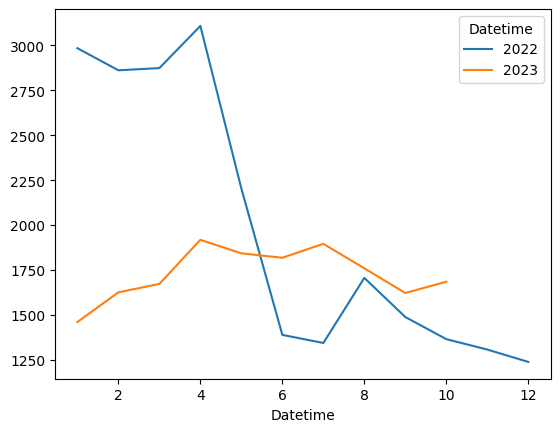

In [66]:
eth.groupby([eth.index.month,eth.index.year])['close'].mean().unstack().plot()

<Axes: xlabel='month'>

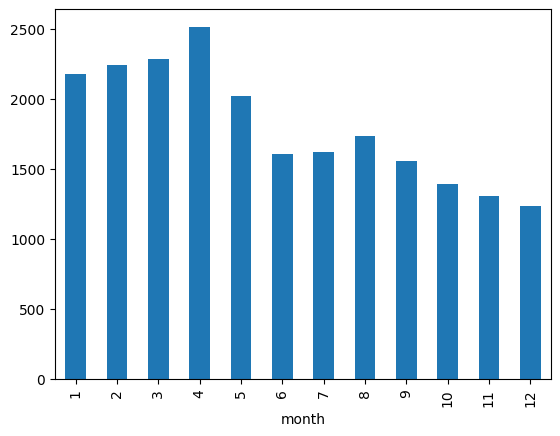

In [67]:
eth.groupby('month')['close'].mean().plot(kind='bar')

In [ ]:
sns.histplot(eth.resample='4H')

In [69]:
eth.tail()

,open,high,low,close,volume,month,year,weekday,high_low_diff
Datetime,,,,,,,,,
2023-10-03 15:00:00+00:00,1648.991821,1651.977173,1644.496460,1648.375366,799744,10,2023,Tuesday,7.480713
2023-10-03 16:00:00+00:00,1648.843140,1652.712524,1647.076416,1651.549683,3734016,10,2023,Tuesday,5.636108
2023-10-03 17:00:00+00:00,1651.387695,1657.706665,1651.261108,1655.650024,35880448,10,2023,Tuesday,6.445557
2023-10-03 18:00:00+00:00,1655.490234,1655.868408,1649.780151,1649.780151,5752320,10,2023,Tuesday,6.088257
2023-10-03 19:00:00+00:00,1649.481812,1654.163330,1647.412842,1653.914551,0,10,2023,Tuesday,6.750488


<Axes: xlabel='Datetime'>

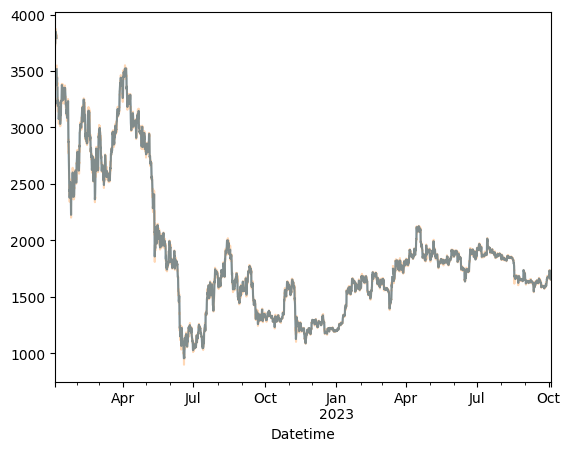

In [70]:
eth.close.resample('4h').mean().plot(alpha=.8)
eth.close.resample('1h').mean().plot(alpha=.3)

# Split

In [71]:
train_size = int(eth.shape[0] * .9)
test_size = int(eth.shape[0] * .1)

test_end_index = train_size + test_size


In [72]:
train = eth.close[:train_size]
test = eth.close[train_size:test_end_index]

In [73]:
print(f'Train shape: {train.shape}, Test shape: {test.shape} , Eth shape: {eth.shape}')

Train shape: (13751,), Test shape: (1527,) , Eth shape: (15279, 9)


In [74]:
# in order to use the prophet model, must rename date as ds and target feature as y
train_model = train.reset_index()
train_model = train_model.rename(columns={'Datetime':'ds', 'close':'y'})
test_model = test.reset_index()
test_model = test_model.rename(columns={'Datetime':'ds', 'close':'y'})

In [75]:
train_model.ds = train_model.ds.astype('datetime64[ns]')
test_model.ds = test_model.ds.astype('datetime64[ns]')
train_model_fit = train_model.copy()

## Split using SKLearn (Did not use)

In [76]:
# dtscv = TimeSeriesSplit(n_splits=3)

In [77]:
# for train_index, test_index in tscv.split(X):

#     X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Finding Baselines
  - Last Observed Value
  - Simple Average
  - Moving Average

In [162]:
def evaluate(test_target=test_model.y, pred_target=yhat_df.close):
    '''
    This function will take the actual values of the target_var from validate,
    and the predicted values stored in yhat_df,
    and compute the rmse, rounding to 0 decimal places.
    it will return the rmse.
    '''
    rmse = round(sqrt(mean_squared_error(test_model[test_target], yhat_df[pred_target])), 0)
    return rmse

In [202]:
def metrics_dataframe(model,RMSE):
    '''
    Keep track and automatically append data to compare models.
    '''
    metrics_df = pd.DataFrame(data=[
            {
                'model':model,
                'rmse':RMSE
            }
            ])
    return metrics_df

def save_metrics(df, model, RMSE):
    df.loc[len(df)] = [model, RMSE]
    df = df[~df.duplicated('model')]
    return df

## Last Observed

In [174]:
# last item in close
last_close = train[-1:][0]

yhat_df = pd.DataFrame(
    {'close': [last_close]},
    index=test_model.index)



In [158]:
sqrt(mean_squared_error(y_true=test_model.y ,y_pred= yhat_df.close))

163.6718720392038

In [209]:
metrics_df = metrics_dataframe(model = 'last-observed' ,RMSE=164)

## Simple Average

In [222]:
# last item in close
close_avg = train.mean()

yhat_df = pd.DataFrame(
    {'avg': [close_avg]},
    index=test_model.index)


In [223]:
sqrt(mean_squared_error(y_true=test_model.y ,y_pred= yhat_df.avg))

220.69901279666098

In [224]:
sqrt(mean_squared_error(y_true=test_model.y ,y_pred= yhat_df.avg))

220.69901279666098

In [225]:
save_metrics(df=metrics_df,model='rolling-avg', RMSE=220)

,model,rmse
0,last-observed,164
1,simple-avg,221
2,rolling-avg,221


## Moving Average

In [216]:
period = 40

# last item in close
rolling = round(train.rolling(period).mean()[-1], 2)

yhat_df = pd.DataFrame(
    {'rolling': [rolling]},
    index=test_model.index)

# Initial Prophet model has been fit on about 19 months of prior data and can now be used to make predictions -- this will be used to predict on about 2 months of most recent data (test)

In [80]:
m = Prophet(yearly_seasonality=False, changepoint_prior_scale=.1)

In [81]:
train_model_fit

,ds,y
0,2022-01-03 19:00:00,3753.413574
1,2022-01-03 20:00:00,3702.529785
2,2022-01-03 21:00:00,3728.064697
3,2022-01-03 22:00:00,3752.556396
4,2022-01-03 23:00:00,3761.077637
...,...,...
13746,2023-07-31 23:00:00,1856.440918
13747,2023-08-01 00:00:00,1861.971680
13748,2023-08-01 01:00:00,1852.625000
13749,2023-08-01 02:00:00,1829.110962


In [82]:
model = m.fit(train_model_fit)

## Forecast DF with predicted values

In [83]:
future = model.make_future_dataframe(periods=40, freq='H')
forecast = model.predict(future)

# Test predicted

In [84]:
testmodel_forecast = model.predict(test_model)

## Exploring Forecast for train and test

In [85]:
forecast[['ds','trend','weekly','daily','yhat']]

,ds,trend,weekly,daily,yhat
0,2022-01-03 19:00:00,3707.807459,-7.039113,0.122847,3700.891193
1,2022-01-03 20:00:00,3705.398061,-6.637492,0.174786,3698.935356
2,2022-01-03 21:00:00,3702.988664,-6.193226,0.394578,3697.190016
3,2022-01-03 22:00:00,3700.579266,-5.707836,0.622544,3695.493974
4,2022-01-03 23:00:00,3698.169868,-5.183207,0.619605,3693.606266
...,...,...,...,...,...
13786,2023-08-02 15:00:00,1849.343886,9.788752,0.591912,1859.724550
13787,2023-08-02 16:00:00,1849.330029,9.434071,0.517943,1859.282043
13788,2023-08-02 17:00:00,1849.316172,9.056482,0.393146,1858.765800
13789,2023-08-02 18:00:00,1849.302314,8.659447,0.231932,1858.193693


In [86]:
testmodel_forecast[['ds','trend','weekly','daily','yhat']]

,ds,trend,weekly,daily,yhat
0,2023-08-01 04:00:00,1849.828895,-2.061272,-0.986220,1846.781403
1,2023-08-01 05:00:00,1849.815038,-1.359342,-0.667524,1847.788171
2,2023-08-01 06:00:00,1849.801180,-0.640176,-0.425544,1848.735460
3,2023-08-01 07:00:00,1849.787323,0.092126,-0.371270,1849.508179
4,2023-08-01 08:00:00,1849.773465,0.833322,-0.412260,1850.194527
...,...,...,...,...,...
1522,2023-10-03 14:00:00,1828.737949,5.221108,0.627826,1834.586883
1523,2023-10-03 15:00:00,1828.724091,5.901698,0.591912,1835.217701
1524,2023-10-03 16:00:00,1828.710234,6.556668,0.517943,1835.784845
1525,2023-10-03 17:00:00,1828.696377,7.182209,0.393146,1836.271731


<Axes: xlabel='Datetime', ylabel='y'>

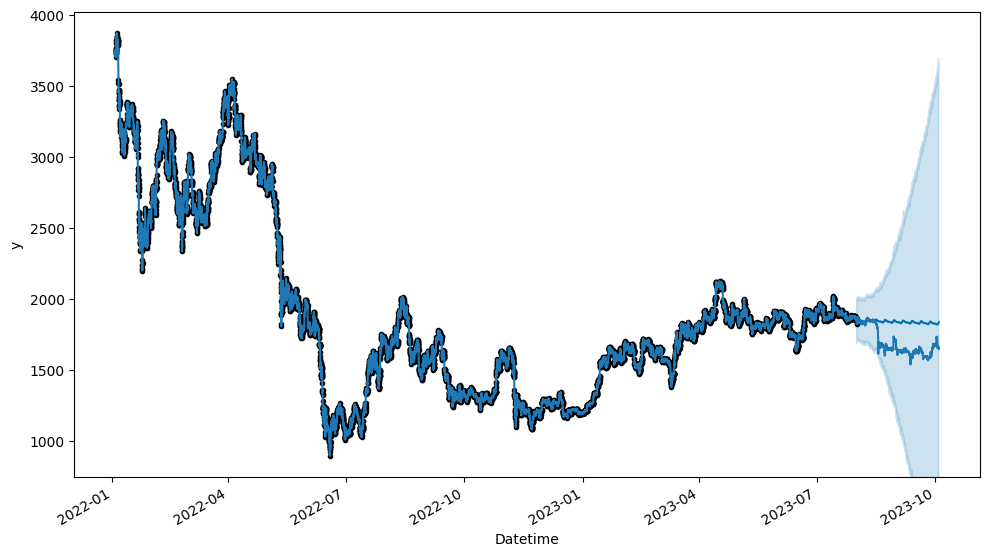

In [87]:
model.plot(testmodel_forecast)
eth.close.plot()

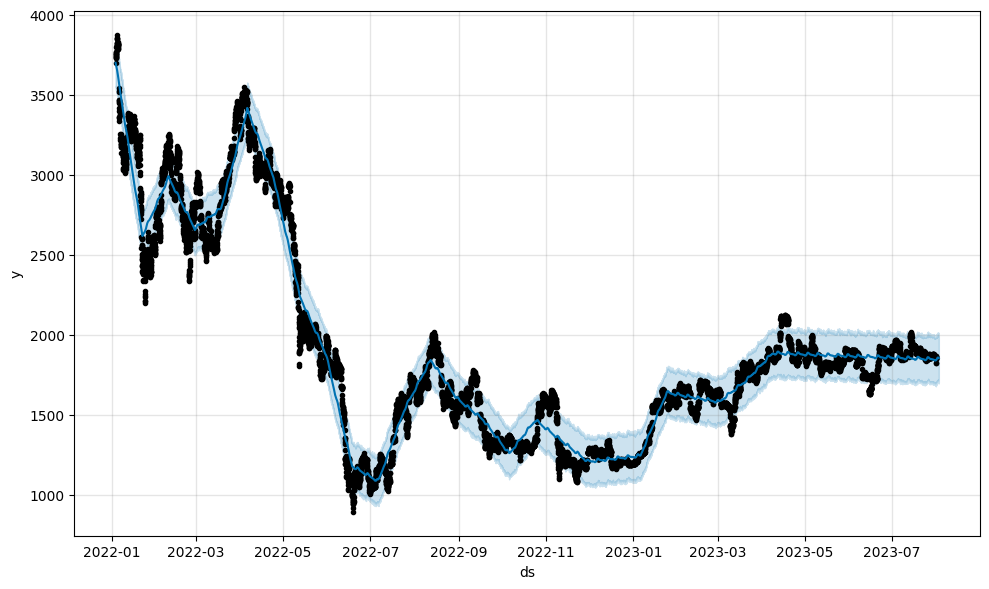

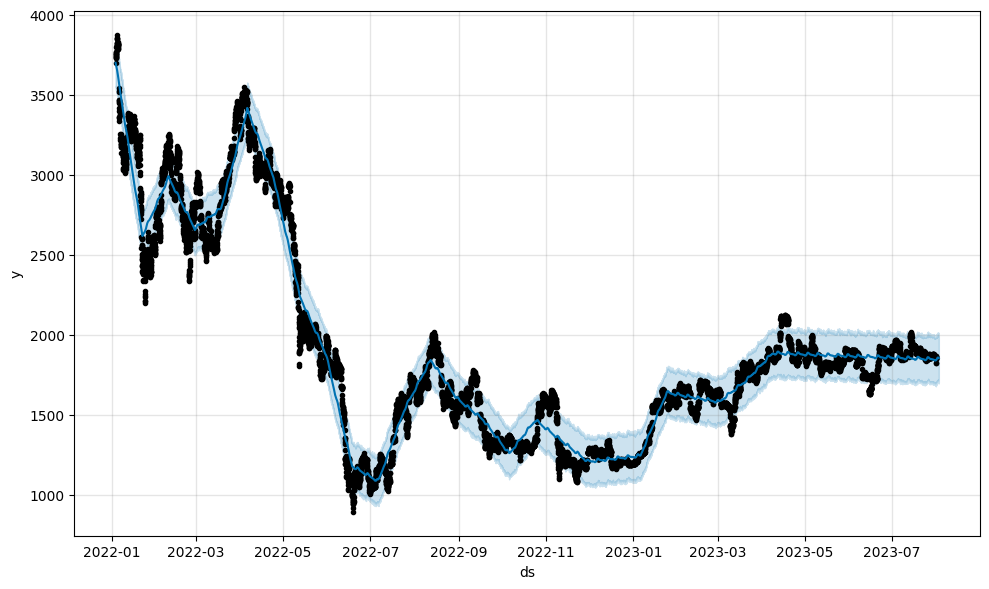

In [88]:
m.plot(forecast)

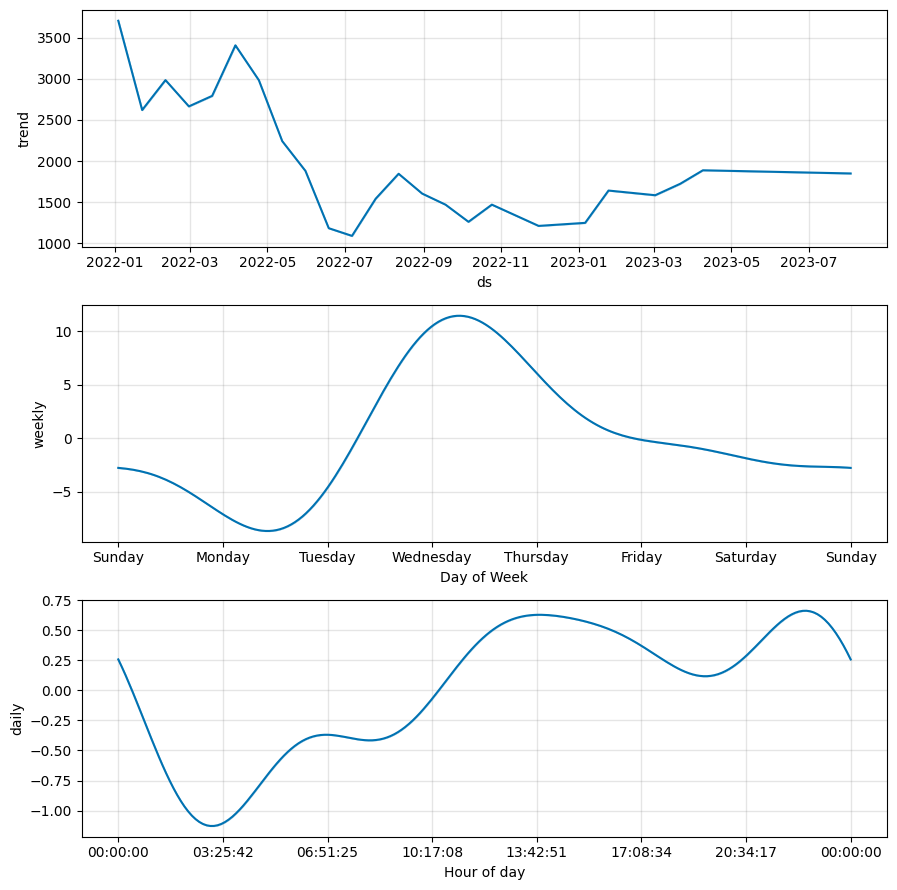

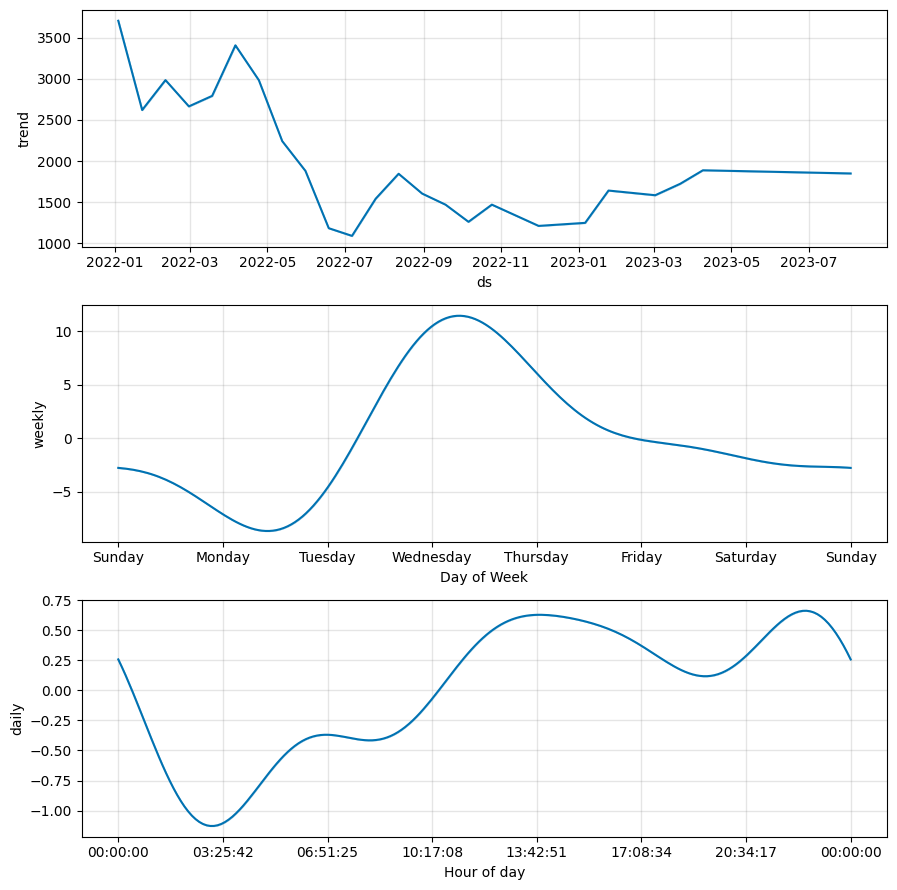

In [89]:
m.plot_components(forecast)

# Parameter Tuning

In [90]:
# importing US holidays for model date identification

import holidays

holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2023]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [91]:
p_grid = {
          'seasonality_mode':('multiplicative','additive'),
          'holidays_prior_scale':[3,4,5,6,7],
          'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
          'changepoint_range':[0.65,0.70,0.75,0.80,0.85]
          }

grid = ParameterGrid(p_grid)

its = 0
for p in grid:
  its = its+1

print(f'Total number of models: {its}')

Total number of models: 250


In [125]:
train_model.loc[2170]

ds    2022-04-04 16:00:00
y             3451.406738
Name: 2170, dtype: object

In [ ]:
model_parameters = pd.DataFrame(columns = ['MAPE','RMSE','Parameters'])
i = 0
for x in grid:
    test = pd.DataFrame()
    i += 1
    print(f'Num of Iteration: {i} of {its}')
    print(x)
    np.random.seed(4343)
    train_model_loop =Prophet(
                         changepoint_prior_scale = x['changepoint_prior_scale'],
                         holidays_prior_scale = x['holidays_prior_scale'],
                         seasonality_mode = x['seasonality_mode'],
                         weekly_seasonality= True,
                         daily_seasonality = True,
                         yearly_seasonality= False,
                         #holidays=holiday,
                         interval_width=0.95)
    # train_model_loop.add_country_holidays(country_name='US')
    # Removed holidays due to the low factor of importance for cryptocurrency trading, this resulted in
    # marginal increases to accuracy
    train_model_loop.fit(train_model)
    train_forecast = train_model_loop.make_future_dataframe(periods=120, freq='H',include_history = False)
    train_forecast = train_model_loop.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    MAPE = mean_absolute_percentage_error(test_model.y.tail(120),abs(test[['yhat']]))
    RMSE = sqrt(mean_squared_error(test_model.y.tail(120),abs(test[['yhat']])))
    print('Mean Absolute Percentage Error(MAPE): +++++++',round(MAPE * 100, 4) )
    print('Root Mean Squared Error(RMSE): +++++++',round(RMSE, 4) )
    model_parameters = model_parameters.append({'MAPE':round(MAPE * 100, 2),'Parameters':x},ignore_index=True)

In [ ]:
# saved_params = model_parameters.copy()

In [ ]:
pd.set_option('display.max_colwidth', None)
saved_params[saved_params['MAPE'] == 8.30]

In [ ]:
saved_params.sort_values('MAPE',ascending=True,inplace=True)

In [ ]:
saved_params.Parameters.iloc[208]

In [ ]:
# exporting hyperparams as csv to save data

# saved_params.to_csv('hyperparams.csv')